In [33]:
import flopy as fp
from flopy.utils import GridIntersect
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import sys
import copy

sys.path.insert(1, '../../modules')
# import modules
from Rouss import *
from Rouss3D import *
from ZoneBudget_ludo import *

In [34]:
sim_name = "pest_3D_R"
org = "org_model"
ws = "workspace"
ref_dr = "200models_ref"

if ws not in os.listdir():
    shutil.copytree(org,ws)
if ref_dr not in os.listdir():
    os.makedirs(ref_dr)
sim = fp.mf6.MFSimulation.load(sim_name,sim_ws=org)
sim.exe_name = "../../exe/mf6.exe"
sim.set_sim_path(ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package wel...
    loading package rch...
    loading package rch...
    loading package rch...
    loading package wel...
    loading package chd...
    loading package wel...
    loading package drn...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package obs...
  loading ims package pest_3d_r...


In [35]:
m = sim.get_model()
grid = m.modelgrid
ix = GridIntersect(grid)
top = m.dis.top.array
idomain = m.dis.idomain.array
# m.remove_package("npf")
# m.remove_package("irr")
m.remove_package("obs")

In [36]:
wel_q_org = m.wel.stress_period_data.array[0].q.copy()
pagr_org = m.p_agr.stress_period_data.array[0].recharge.copy()

In [39]:
# load parameters
kQ = np.load("data_200modelsV2//kQ.npy")
kQ[:,:,140:] = 2e-3
kPc = np.load("data_200modelsV2/kPc.npy")
kPc[:,:,140:] = 1e-4
kep = np.load("data_200modelsV2/kep.npy")
kpms = np.load("data_200models/kpms.npy")
kqm = np.load("data_200modelsV2/kqm.npy")
irr = np.load("data_200modelsV2/irr.npy")
r_cond = np.load("data_200modelsV2/cond_riv.npy")


In [74]:
def pred(elev_mar=0,coeff_p=1,i_rch="today",coeff_rch=1,n_models=1,directory="ws",im=None):
    
    
    if directory not in os.listdir():
        os.makedirs(directory)
    
    # recharge
    m.remove_package("rch")
    
    rch_path="../../data/recharge/recharge_p.tif" # path to rch
    rch_path_2050 = "../../data/changements_clim/rast_rch_2050.tif"
    rch_path_2080 = "../../data/changements_clim/rast_rch_2080.tif"

    ## select recharge (0 : today, 1 : 2050, 2 : 2080)
    if i_rch == 2050:
        rch_path = rch_path_2050
    elif i_rch == 2080:
        rch_path = rch_path_2080
    elif i_rch == "today":
        pass
    else:
        raise Exception("Choose between 2050, 2080 or today")

    rch = rspl_rast(rch_path,grid) # resample to grid
    rch[rch<0]=np.mean(rch[rch>0]) # replace negative values by a mean

    rch[np.abs(idomain).sum(0)==0]=0 # remove some rch
    rch[idomain[0]==1]=0 # remove some rch
    for cell in m.eta.stress_period_data.array[0].cellid:
        rch[cell[1],cell[2]]=0

    rch = liss_mob(rch,5)

    # make a list for rch package
    rch_lst=[]
    for icell in up_act_cell(idomain):
        irow = icell[1]
        icol = icell[2]
        if rch[irow,icol] > 0:
            rch_lst.append(((icell),coeff_rch*rch[irow,icol]/1000/365/86400)) ## apply recharge coeff
    
    rch = fp.mf6.ModflowGwfrch(m,pname = "rch",maxbound=len(rch_lst),stress_period_data=rch_lst,save_flows=True)
    rch.write()
 
    ## prélèvements
    m.wel.stress_period_data.array[0].q = wel_q_org*coeff_p
    m.wel.write()
    
    m.p_agr.stress_period_data.array[0].recharge = pagr_org*coeff_p
    m.p_agr.write()
    
    ## elev_mar
    new_fhead = -5+(elev_mar+5)*1.025
    
        #update sea
#         chd_lst = []
#         for cid in m.sea.stress_period_data.array[0].cellid:
#             zi = top[cid[1],cid[2]]
#             chd = zi+(elev_mar-zi)*1.025
#             if chd < 0:
#                 chd = 0.1
#             chd_lst.append((cid,chd))
    m.sea.stress_period_data.array[0].head = new_fhead
    m.sea.write()

    #update ponds
    m.eta.stress_period_data.array[0].elev = new_fhead
    m.eta.write()
    
    if im is None:
        models = range(n_models)
    else : 
        models = [im]
    for i_model in models:
        
        ## update npf, irr and rivers ##
            #update npf
            
        m.remove_package("npf")
        m.remove_package("irr")
        
        k = []
        k.append(kqm[i_model,0,0])
        k.append(kQ[i_model])
        k.append(kep[i_model,0,0])
        k.append(kPc[i_model])
        k.append(kpms[i_model,0,0])
        npf = fp.mf6.ModflowGwfnpf(m,pname="npf",k=k,save_flows=True,save_specific_discharge=False)
        npf.write()

        #update irr
        irrig = fp.mf6.ModflowGwfrcha(m,pname="irrig",filename="irri.rch",irch=2,recharge=irr[i_model],save_flows=True)
        irrig.write()

        #update rivers
        conds = r_cond[i_model]
        r_pos = (0,5,3,2,4,1)
        for i in range(len(m.riv)):
            m.riv[i].stress_period_data.array[0].cond = conds[r_pos[i]]
            m.riv[i].write()   
        
        
        sim.run_simulation(silent=True)
        
        # outputs #
        shutil.copyfile(os.path.join(ws,sim_name+".hds"),os.path.join(directory,sim_name+"_{}.hds".format(i_model)))
        shutil.copyfile(os.path.join(ws,sim_name+".cbc"),os.path.join(directory,sim_name+"_{}.cbc".format(i_model)))

In [75]:
#ref
pred(n_models=1,directory="200models_ref",im=10)

In [9]:
# for i_model in range(200):

#     #update npf
#     k = []
#     k.append(kqm[i_model,0,0])
#     k.append(kQ[i_model])
#     k.append(kep[i_model,0,0])
#     k.append(kPc[i_model])
#     k.append(kpms[i_model,0,0])
#     npf = fp.mf6.ModflowGwfnpf(m,pname="npf",k=k)
#     npf.write()

#     #update irr
#     irrig = fp.mf6.ModflowGwfrcha(m,pname="irr",filename="irr.rch",irch=2,recharge=irr[i_model],save_flows=True)
#     irrig.write()

#     #update rivers
#     for i in range(len(m.riv)):
#         m.riv[i].stress_period_data.array[0].cond = r_cond[0,i]
#         m.riv[i].write()


#     sim.run_simulation(silent=True)
#     shutil.copyfile(os.path.join(ws,sim_name+".hds"),os.path.join(ref_dr,sim_name+"_{}.hds".format(i_model)))
#     shutil.copyfile(os.path.join(ws,sim_name+".cbc"),os.path.join(ref_dr,sim_name+"_{}.cbc".format(i_model)))

In [66]:
pred1_dr = "200models_s1"
pred2_dr = "200models_s2"
pred3_dr = "200models_s3"

for dr in [pred1_dr,pred2_dr,pred3_dr]:
    if dr not in os.listdir():
        os.makedirs(dr)

In [67]:
# scenarios
pred(elev_mar=0,coeff_p=1,i_rch=2080,coeff_rch=1,n_models=150,directory=pred1_dr)
pred(elev_mar=0.35,coeff_p=1,i_rch=2080,coeff_rch=1,n_models=150,directory=pred2_dr)
pred(elev_mar=0.35,coeff_p=1.2,i_rch=2080,coeff_rch=1,n_models=150,directory=pred3_dr)

In [68]:
ws_load = pred3_dr
imodel = 6

h = get_heads(sim_name+"_{}".format(imodel),ws_load)
b = get_cbc(sim_name+"_{}".format(imodel),ws_load)

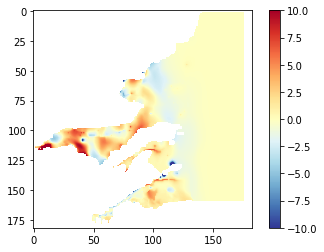

In [69]:
h[h > 1300] = np.nan
plt.imshow(h[1]-h[4]4,cmap="RdYlBu_r")
plt.colorbar()

In [112]:
K6

nan

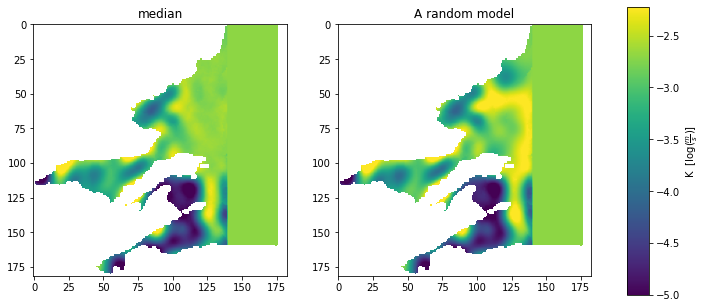

In [114]:
K = kQ.copy()
Kmed = np.median(K,axis=0)
Kmed[idomain[1]!= 1]= np.nan
K6 = K[7]
K6[idomain[1]!= 1] = np.nan

fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.log10(Kmed))
plt.title("median")
plt.subplot(1,2,2)
g = plt.imshow(np.log10(K6))
plt.title("A random model")

cbaxes = fig.add_axes([0.95, 0.1, 0.03, 0.8]) 
cb = plt.colorbar(g, cax = cbaxes)
cb.set_label(r"K  [log($\frac{m}{s}$)]")

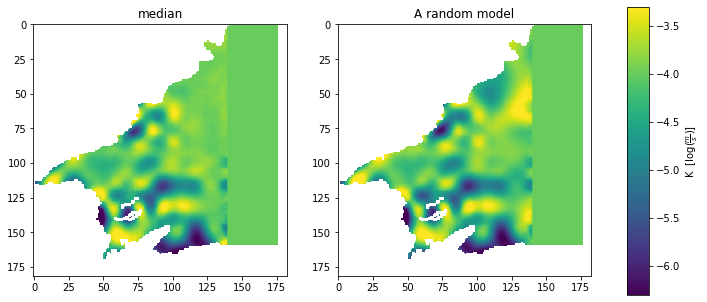

In [115]:
K = kPc.copy()
Kmed = np.median(K,axis=0)
Kmed[idomain[3]!= 1]= np.nan
K6 = K[7]
K6[idomain[3]!= 1] = np.nan

fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.log10(Kmed))
plt.title("median")
plt.subplot(1,2,2)
g = plt.imshow(np.log10(K6))
plt.title("A random model")

cbaxes = fig.add_axes([0.95, 0.1, 0.03, 0.8]) 
cb = plt.colorbar(g, cax = cbaxes)
cb.set_label(r"K  [log($\frac{m}{s}$)]")

In [50]:
from Zone_Budget_mf6 import Zb

In [72]:
%%time
#create the zones
nlay = 5
nrow = 182
ncol = 183
a = np.array([1,2,4,4,6]) # Quat, eponte + PC, PMS
a = a[np.newaxis,np.newaxis,:]
zones = np.ones([nlay,nrow,ncol])*a.T
#zones[idomain==0]=0
#zones[0][idomain[0]==1]=0 # Quat marin
zones[1][idomain[0]==1]=3 # Quat marin
zones[3][idomain[0]==1]=5 # Pc marin

dic_zones = {1:"interfQ",
            2 : "Q",
            3 : "Q marin",
            4 : "PC",
            5 : "PC marin",
            6 : "PMS"} # dic to attribute zone names !

# initiate object
zb = Zb(zones,sim_name,ws,cbc=b,dic_zones=dic_zones,m_n=1)
DF_Budg = zb.get_Budget() # get DF budget

Wall time: 2.02 s


In [73]:
DF_Budg.replace(0,"/")

interfQ                         Q                  Q marin  \
                 FROM           TO         FROM          TO         FROM   
WEL                 /            /            /    0.541459            /   
CORB                /            /            /           /            /   
THUIR               /            /     0.140625           /            /   
ETA                 /            /            /    0.442758            /   
AGLY                /            /    0.0430227   0.0965188            /   
TET                 /            /     0.247741    0.475349            /   
REA                 /            /    0.0851012   0.0267265            /   
CANT                /            /      0.16149    0.132466            /   
TECH                /            /     0.237144    0.133112            /   
BOL                 /            /     0.119588  0.00209157            /   
RCH                 /            /      1.38901           /            /   
IRRIG               /            /     0.857829           /            /   
P_AGRI              /            /            /     0.49786            /   
SEA       0.000131939     0.733488            /           /            /   
interfQ             /            /            /           /  0.000131939   
Q                   /            /            /           /     0.543652   
Q marin      0.719506  0.000131939  1.03727e-05    0.543652            /   
PC                  /            /     0.635695      1.0253     0.176126   
PC marin    0.0139817            /            /           /            /   
PMS                 /            /            /           /            /   

                                PC                 PC marin               \
                   TO         FROM          TO         FROM           TO   
WEL                 /            /    0.550832            /            /   
CORB                /    0.0989693           /            /            /   
THUIR               /     0.159375           /            /            /   
ETA                 /            /           /            /            /   
AGLY                /            /           /            /            /   
TET                 /  0.000353285  0.00680088            /            /   
REA                 /    0.0290323           /            /            /   
CANT                /     0.202389   0.0296421            /            /   
TECH                /            /           /            /            /   
BOL                 /            /           /            /            /   
RCH                 /     0.653796           /            /            /   
IRRIG               /            /           /            /            /   
P_AGRI              /            /    0.309249            /            /   
SEA                 /            /           /            /            /   
interfQ      0.719506            /           /            /    0.0139817   
Q         1.03727e-05       1.0253    0.635695            /            /   
Q marin             /  0.000392965    0.176126            /            /   
PC        0.000392965            /           /     0.198903     0.185266   
PC marin            /     0.185266    0.198903            /            /   
PMS                 /     0.332232    0.779916  0.000849398  0.000482574   

                  PMS               
                 FROM           TO  
WEL                 /       0.5536  
CORB         0.101031            /  
THUIR               /            /  
ETA                 /            /  
AGLY                /            /  
TET                 /            /  
REA         0.0111297            /  
CANT                /   0.00261217  
TECH                /  0.000862746  
BOL                 /            /  
RCH         0.0160878            /  
IRRIG               /            /  
P_AGRI              /    0.0181513  
SEA                 /            /  
interfQ             /            /  
Q                   /            /  
Q 